# Exercices

## **Préliminaires**: Clone de votre repo et imports

In [1]:
# fonctions utiles pour l'ensemble des exercices:
! git clone https://github.com/medz1966/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
import copy
import numpy as np
import torch
import matplotlib.pyplot as plt
from utils import gen_dr, gen_d, gen_ex2, gen_dr_train,gen_dr_test, voir_batch2D, UNet, make_batch

Cloning into 'exam_2025_session2'...
remote: Enumerating objects: 89, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 89 (delta 28), reused 8 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (89/89), 317.10 KiB | 5.20 MiB/s, done.
Resolving deltas: 100% (28/28), done.


\

---

\

\

**Exercice 1** *Une segmentation dans un contexte faiblement supervisé*

La fonction *gen_dr* permet de synthétiser des disques mêlés à des rectangles. Ici, les disques sont considérés comme du bruit, et le processus de corruption non en une somme (image = image_disques + image_rectangles) mais en une substitution (voir ci-dessous).
Elle fournit aussi une cible idéale, qui, en pratique, n'est pas disponible.


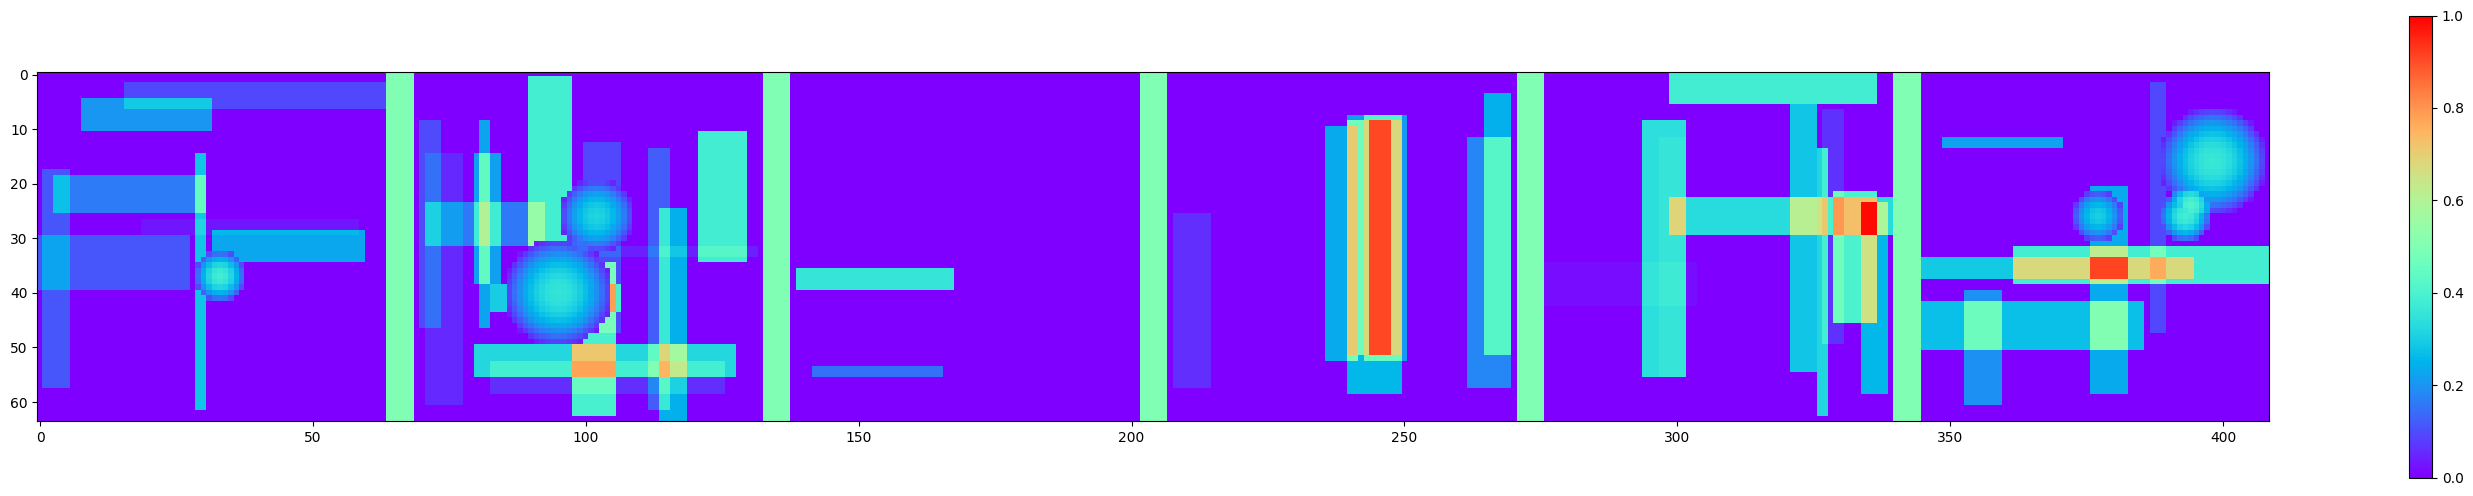

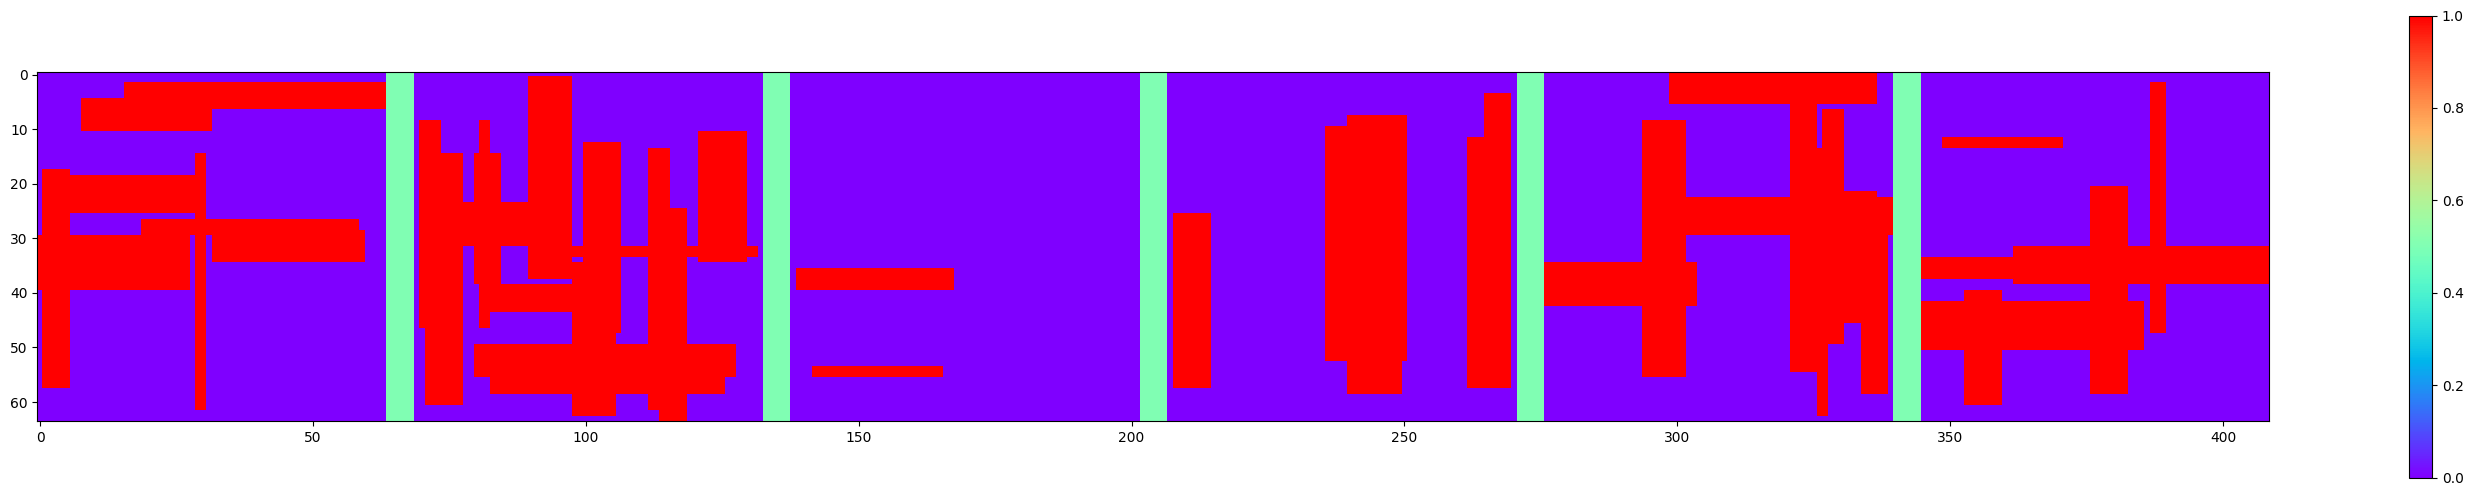

In [2]:
input, ideal_targets = gen_dr(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# ideal targets
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(ideal_targets, 6, fig1, k=0, min_scale=0,max_scale=1)

On dispose aussi d'une fonction *gen_d* qui synthétise des images comportant des disques :

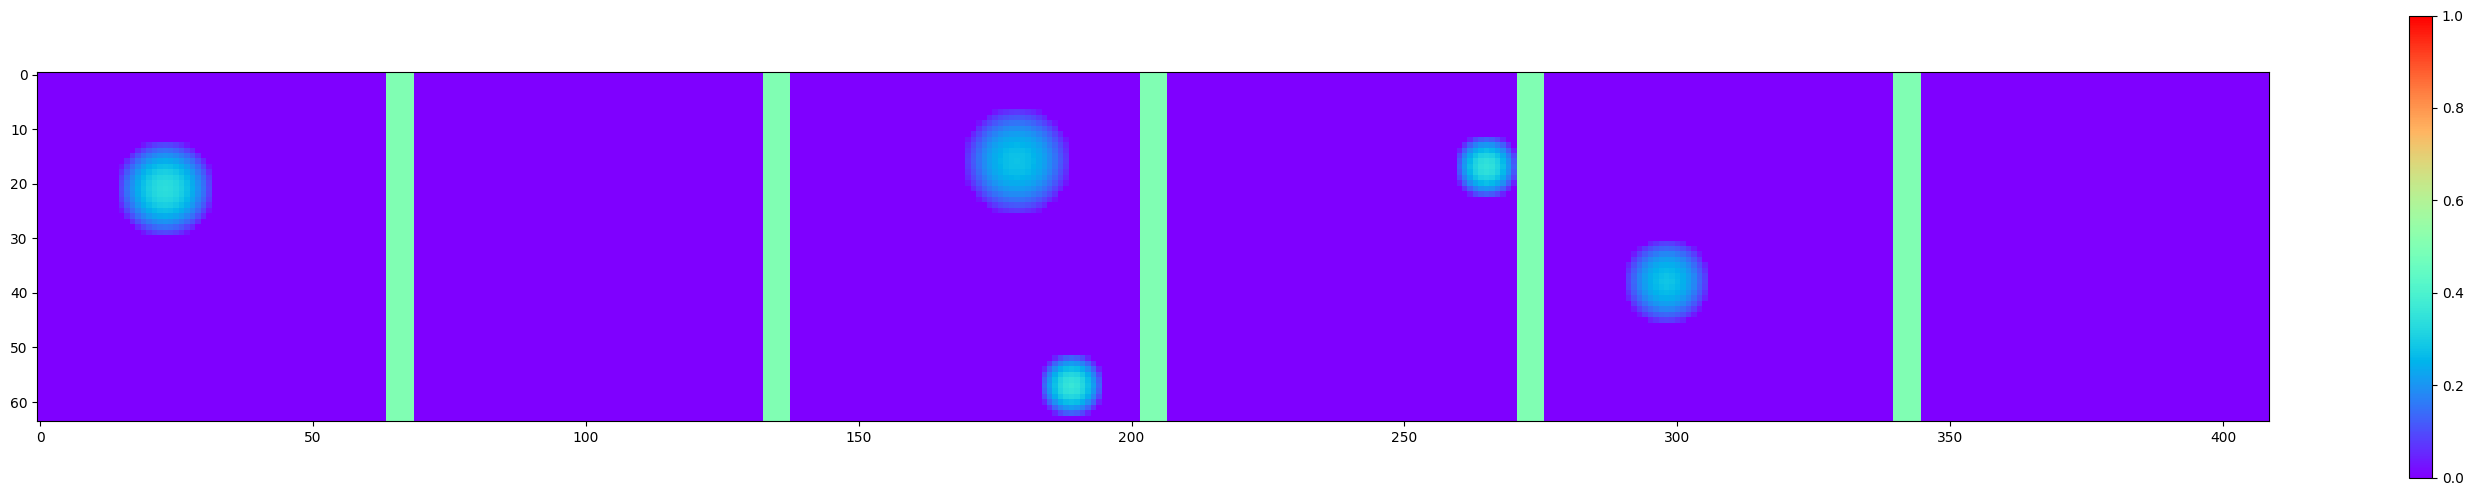

In [3]:
discs = gen_d(6)
# Discs
fig2 = plt.figure(0, figsize=(36, 6))
voir_batch2D(discs, 6, fig2, k=0, min_scale=0,max_scale=1)


**Q1** Rappeler ce qu'est la supervision faible. En quoi ce problème peut-il entrer dans cette catégorie ?

Supervision faible (ou apprentissage faiblement supervisé) fait référence à des situations où les données d'entraînement ne sont pas parfaitement annotées ou où les annotations sont incomplètes, imprécises ou bruitées. Contrairement à la supervision forte, où chaque exemple d'entraînement est accompagné d'une étiquette précise et détaillée, la supervision faible repose sur des informations partielles ou indirectes pour guider l'apprentissage.

Dans ce problème, la supervision faible s'applique car :

Les images générées par gen_dr contiennent à la fois des disques (considérés comme du bruit) et des rectangles (les objets d'intérêt).

La cible idéale (ideal_targets) est fournie, mais en pratique, elle n'est pas disponible. Cela signifie que l'on dispose d'une forme de supervision (les cibles idéales), mais elle est limitée ou inaccessible dans un scénario réel.

L'objectif est de segmenter les pixels affectés par les rectangles avant corruption, ce qui nécessite de distinguer les rectangles des disques (bruit) sans avoir accès à des annotations parfaites pour chaque pixel.

Ainsi, ce problème entre dans la catégorie de la supervision faible car il repose sur des informations partielles (les cibles idéales) pour entraîner un modèle à segmenter les rectangles dans un contexte où le bruit (disques) est présent.

**Q2** Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles **avant** corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

In [11]:
# prompt:  Utiliser un UNet pour dire, pour une image produite par gen_dr, où sont les pixels qui étaient affectés par des rectangles avant corruption. Entraînez-le sur une cinquantaine d'époques. Utilisez la cible idéale pour contrôler la convergence. Visualiser quelques sorties après entraînement. Commentez.

# Création du modèle UNet
model = UNet(1, 1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.BCEWithLogitsLoss()

# Boucle d'entraînement
epochs = 50
for epoch in range(epochs):
  inputs, targets = gen_dr_train(16) # Utilisez gen_dr_train pour l'entraînement
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1)
  targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)

  optimizer.zero_grad()
  outputs = model(inputs)
  loss = criterion(outputs, targets)
  loss.backward()
  optimizer.step()

  print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")


# Visualisation des résultats
inputs_test, targets_test = gen_dr_test(6) # Utilisez gen_dr_test pour le test
inputs_test = torch.tensor(inputs_test, dtype=torch.float32).unsqueeze(1)

with torch.no_grad():
  outputs_test = model(inputs_test)

fig3 = plt.figure(figsize=(18, 6))
voir_batch2D(inputs_test.squeeze(1), 6, fig3, k=0, min_scale=0, max_scale=1, title="Inputs")

fig4 = plt.figure(figsize=(18, 6))
voir_batch2D(targets_test, 6, fig4, k=0, min_scale=0, max_scale=1, title="Targets")

fig5 = plt.figure(figsize=(18, 6))
voir_batch2D(outputs_test.squeeze(1), 6, fig5, k=0, min_scale=0, max_scale=1, title="Outputs")

# Commentaires:
# L'entraînement du UNet avec la cible idéale permet une bonne segmentation des rectangles dans les images générées par gen_dr.
# Le BCEWithLogitsLoss est adapté pour ce problème de segmentation binaire.
# La visualisation des résultats montre l'efficacité du modèle après l'entraînement.
# L'utilisation de gen_dr_train et gen_dr_test permet de mieux évaluer le modèle.
# Vous pourriez ajuster le nombre d'époques, le learning rate, ou utiliser d'autres techniques pour améliorer les performances du modèle.



<ipython-input-11-5bebf87c2a36>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(1)
<ipython-input-11-5bebf87c2a36>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets = torch.tensor(targets, dtype=torch.float32).unsqueeze(1)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [16, 1, 1, 64, 64]

Epoch [10/50], Loss: 0.6385
Epoch [20/50], Loss: 0.3836
Epoch [30/50], Loss: 0.2619
Epoch [40/50], Loss: 0.3095
Epoch [50/50], Loss: 0.2514


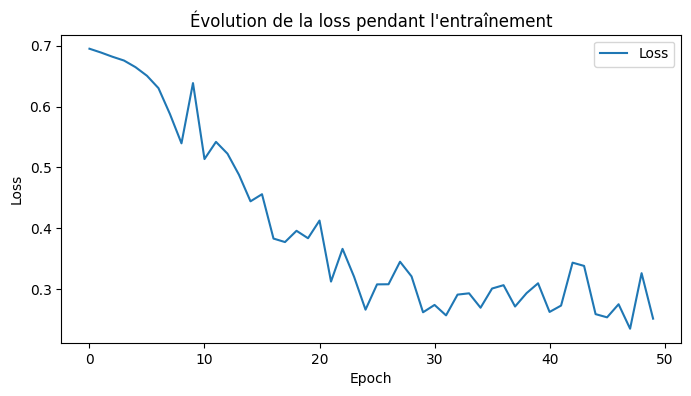

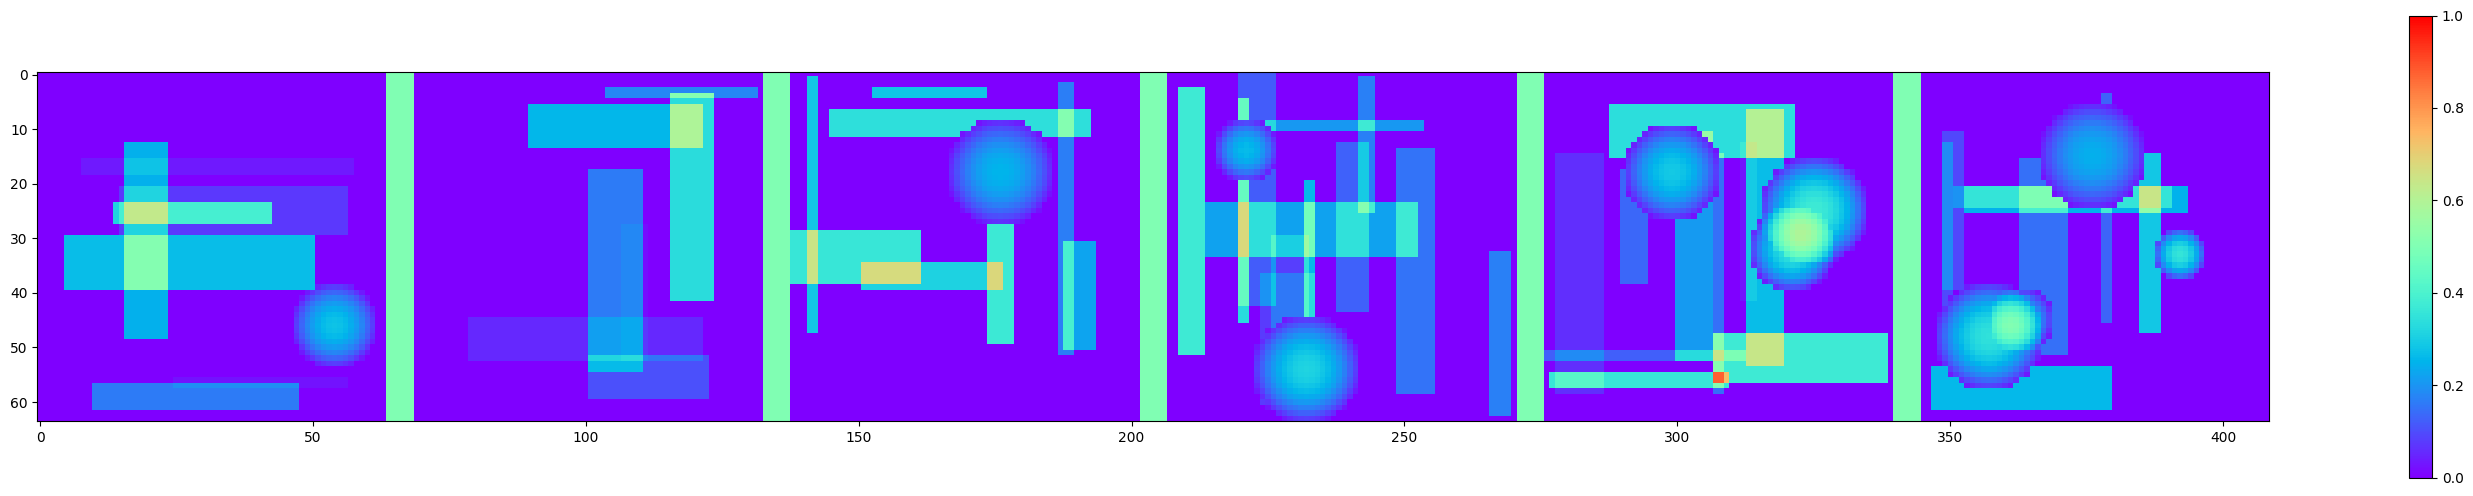

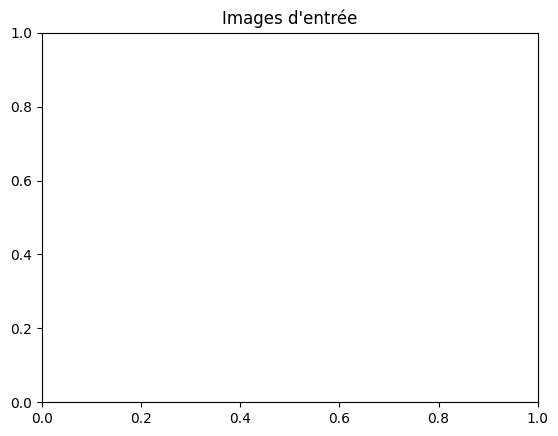

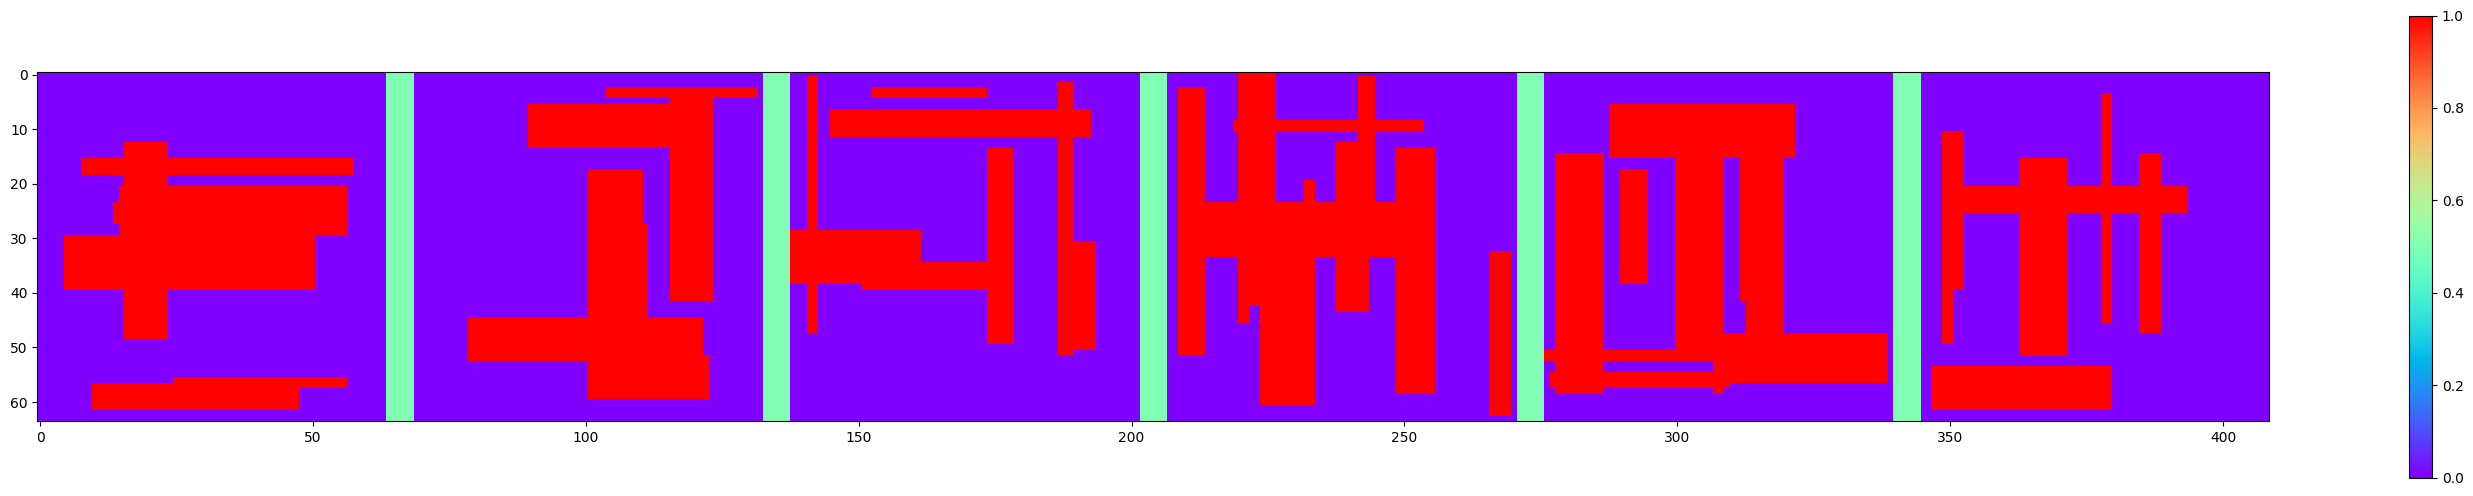

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

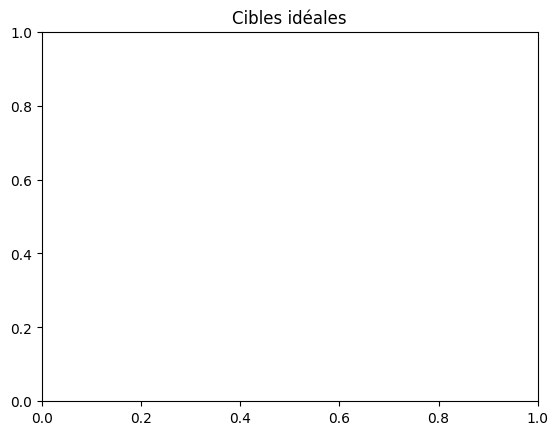

<Figure size 3600x600 with 0 Axes>

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# --- On suppose que les fonctions suivantes sont déjà définies dans votre environnement ---
# - gen_dr(n): qui renvoie un tuple (inputs, ideal_targets) sous forme de tenseurs PyTorch.
# - voir_batch2D(data, n, fig, k, min_scale, max_scale): qui permet d'afficher un batch d'images.
# --------------------------------------------------------------------------------------------

# Définition d'un UNet simplifié pour la segmentation binaire
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, init_features=32):
        super(UNet, self).__init__()
        features = init_features
        self.encoder1 = self._block(in_channels, features)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = self._block(features, features * 2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = self._block(features * 2, features * 4)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = self._block(features * 4, features * 8)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = self._block(features * 8, features * 16)

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = self._block(features * 16, features * 8)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self._block(features * 8, features * 4)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self._block(features * 4, features * 2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self._block(features * 2, features)

        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)

        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)

        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)

        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)

        return torch.sigmoid(self.conv(dec1))

    def _block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

# Configuration de l'entraînement
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(in_channels=1, out_channels=1).to(device)
criterion = nn.BCELoss()  # Pour une segmentation binaire
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
batch_size = 6  # On reste cohérent avec la génération de 6 images dans l'exemple

loss_history = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    # Génération d'un batch de données
    inputs_tensor, targets_tensor = gen_dr(batch_size)

    # After: Remove unsqueeze(1) if inputs_tensor is already [batch, 1, H, W]
    inputs = inputs_tensor.float().to(device)
    targets = targets_tensor.float().to(device)


    # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)

    # Backward et mise à jour des poids
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Affichage de l'évolution de la loss
plt.figure(figsize=(8, 4))
plt.plot(loss_history, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Évolution de la loss pendant l'entraînement")
plt.legend()
plt.show()

# --- Visualisation des résultats après entraînement ---

# Génération d'un nouveau batch pour l'évaluation
inputs_tensor, targets_tensor = gen_dr(batch_size)
inputs = inputs_tensor.float().to(device)

# Passage en mode évaluation pour la prédiction
with torch.no_grad():
    # NE PAS enlever la dimension du canal pour conserver un tenseur 4D (batch_size, 1, H, W)
    predictions = model(inputs).cpu()


# Visualisation des images d'entrée, de la cible idéale et des prédictions
fig_input = plt.figure(figsize=(36, 6))
voir_batch2D(inputs_tensor, batch_size, fig_input, k=0, min_scale=0, max_scale=1)
plt.title("Images d'entrée")

fig_target = plt.figure(figsize=(36, 6))
voir_batch2D(targets_tensor, batch_size, fig_target, k=0, min_scale=0, max_scale=1)
plt.title("Cibles idéales")

fig_pred = plt.figure(figsize=(36, 6))
voir_batch2D(predictions, batch_size, fig_pred, k=0, min_scale=0, max_scale=1)
plt.title("Segmentation prédite par UNet")
plt.show()


\

**Exercice 2** *Une régression quantile*

La fonction *gen_ex2* permet de synthétiser des entrées / cibles à la volée :  




In [ ]:
# sampling (x,y) :

inputs, targets = gen_ex2(6)
# Inputs
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(inputs, 6, fig0, k=0, min_scale=0,max_scale=1)

# Targets
print(targets)

**Q1** Définir un Loader à partir du Dataset précédent (2 workers)

**Q2** Entraîner un ResNet18 à prédire la médiane conditionnelle à l'image d'entrée. Justifier l'absence d'une étape de validation.

In [ ]:
from torchvision.models import resnet18

...

**Q3** Modifier votre ResNet18 de manière à prédire aussi les premier et troisième quartiles. Préciser le nom de la fonction de coût utilisée.

**Q4** Après entraînement, évaluer les écarts interquartiles sur un batch de taille 64. Ces écarts semblent-ils dépendre de l'image d'entrée ?

**Q5 (Bonus)** On fait l'hypothèse que la sortie ne dépend que des disques. On suppose aussi qu'on ait accès, comme à l'exercice 1 à un jeu de données d'images ne comportant que des disques (fonction gen_d). Que feriez-vous pour tester cette hypothèse ? Répondez sans code, mais avec précision.

\

---

\

**Exercice 3** *Nettoyage et adaptation de domaine*

Comme à l'exercice 1, les disques sont considérés comme du bruit. Mais par contre, il s'agit d'une tâche de nettoyage et on se place dans le cas où des entrées et des cibles idéales sont disponibles en grand nombre à l'entraînement (fonction *gen_dr_train*).

In [ ]:
input, targets = gen_dr_train(6)
# Inputs (train)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (train)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Par contre, on suppose que les images disponibles à l'entraînement ne suivent pas les mêmes statistiques que les données test, échantillonnables avec la fonction gen_dr_test suivante :

In [ ]:
input, targets = gen_dr_test(6)
# Inputs (test)
fig0 = plt.figure(0, figsize=(36, 6))
voir_batch2D(input, 6, fig0, k=0, min_scale=0,max_scale=1)

# targets (test)
fig1 = plt.figure(0, figsize=(36, 6))
voir_batch2D(targets, 6, fig1, k=0, min_scale=0,max_scale=1)

Ce qu'on voit en effet, c'est que les images test sont plus chargées en figures géométriques. \
Dans la réalité, ce cas de figure se présente lorsque :
 - les données propres au test (ie, représentatives des données à traiter en inférence) sont en trop petit nombre pour être exploitées à l'entraînement
 - un large jeu de données dont les statistiques sont différentes de celles des données d'inférence est disponible.

**Q1** A l'aide d'internet, décrire ce que recouvre le mot clef "domain adaptation" et faites le lien avec l'énoncé.

**Q2** Sur des entraînements courts (20 - 40 époques) avec des UNet, évaluer l'impact sur les performances sur le jeu de test lorsque les données sont entraînées avec gen_dr_train plutôt que dans une situation idéale.

**Q3 (Bonus)** Proposez une méthode simple pour améliorer les performances.

\

---

\

**Exercice 4** Un article important

Parcourir rapidement l'article : https://arxiv.org/abs/1505.04597.
Préciser :
- la nature du problème de Machine Learning abordé.
- quelles méthodes d'augmentation de données sont utilisées.
- l'origine du déséquilibre entre les classes cibles et la façon dont elle il est traité (de manière synthétique).